In [1]:
from intervaltree import IntervalTree, Interval
from tqdm import tqdm
import logging
import re
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extraction

### Regex

In [2]:
# Regex patterns to extract instructions or symbols from Spike dump
instruction_pattern = re.compile(r"core\s*\d: 0x(?P<pc>\w+) \((?P<inst>\w+)\)")
name_pattern = re.compile(r"core\s*\d:\s*>>>>\s*(?P<name>\w+)")

### Log Parse

In [3]:
# Pass in Spike dump here. We read in and then parse every line
file = "aha-mont64.log"
with open(file) as f:
    lines = f.readlines()

### Basic Block Extraction

In [4]:
# Make initial pass through the Spike dump
# A new interval is recorded when the PC changes by more than 4
# The end of the previous Interval is the PC that was jumped from
# The start of the next Interval is the PC that was jumped to
# No data is stored, speeds up the lookup significantly
start = None
previous = None
intervals = IntervalTree()
for line in tqdm(lines):
    if instruction := instruction_pattern.match(line):
        pc = int(instruction.group("pc"), 16)
        if not start:
            start = pc
        if previous and (abs(pc - previous) > 4):
            intervals[start:previous + 4] = None
            start = pc
        previous = pc

# Ensures that PCs have a one-to-one mapping to an interval
intervals.merge_equals()
intervals.split_overlaps()

100%|████████████████████████████| 2228206/2228206 [00:01<00:00, 1335171.32it/s]


In [5]:
# Assign each interval an index in the BBV vector
# Easier to just instantiate a new tree for lookup later
id = 0
unique_intervals = IntervalTree()
for interval in intervals:
    unique_intervals.addi(interval.begin, interval.end, id)
    id += 1

### Interval Embedding

In [10]:
# Compute the BBV
# Dynamically pass k or a list of k's specifying the interval length
N = len(lines)
ks = range(1000, 10000, 1000)

# Make a second pass through and compute the BBV for each interval for each k
# BBV shape is (basic block, interval) meaning the basic block vector is in the columns
bbvs = {k: np.zeros((len(intervals), N // k + 1)) for k in ks}
for (i, line) in tqdm(enumerate(lines)):
        if instruction := instruction_pattern.match(line):
            pc = int(instruction.group("pc"), 16)
            (interval,) = unique_intervals[pc]
            for (j, k) in enumerate(ks):
                bbvs[k][interval.data, i // k] += 1

2228206it [00:10, 211761.98it/s]


# Analysis

### Optimal Interval Size

Exploring the tradeoff between interval size and rank

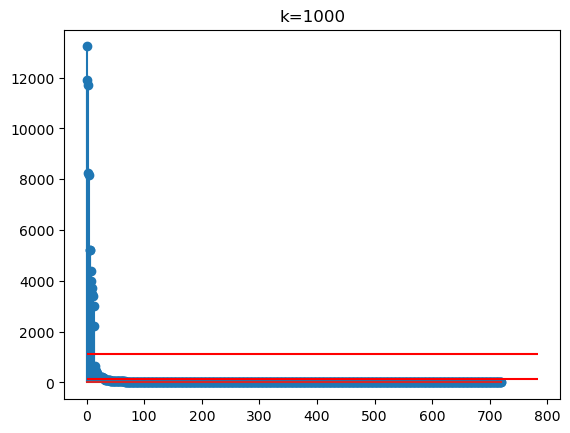

Dimensions: 14


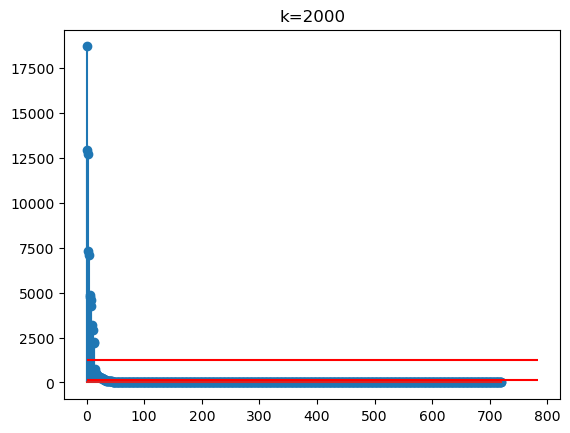

Dimensions: 14


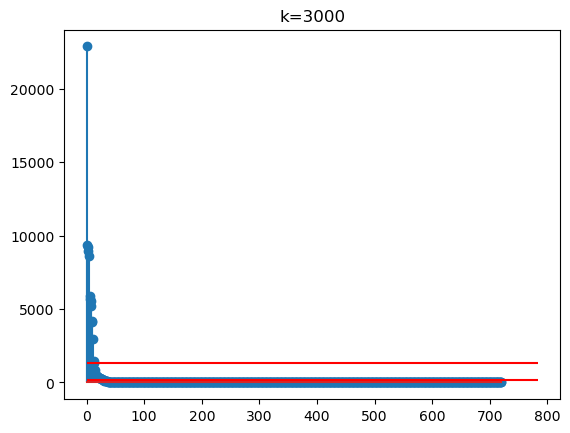

Dimensions: 13


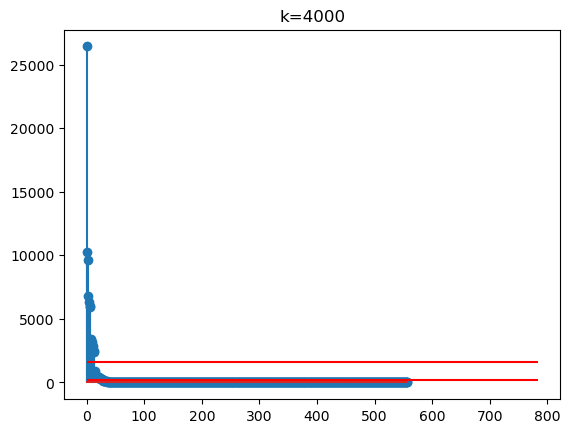

Dimensions: 14


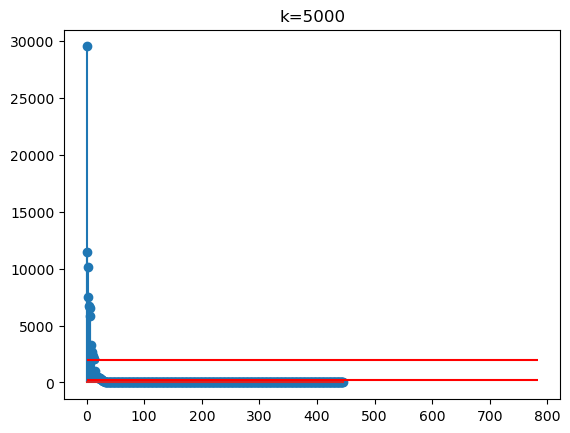

Dimensions: 14


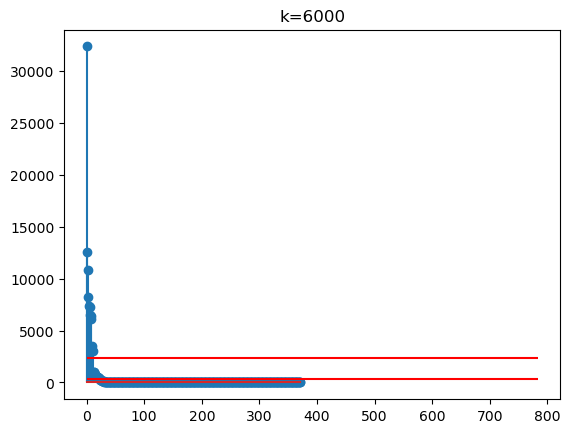

Dimensions: 12


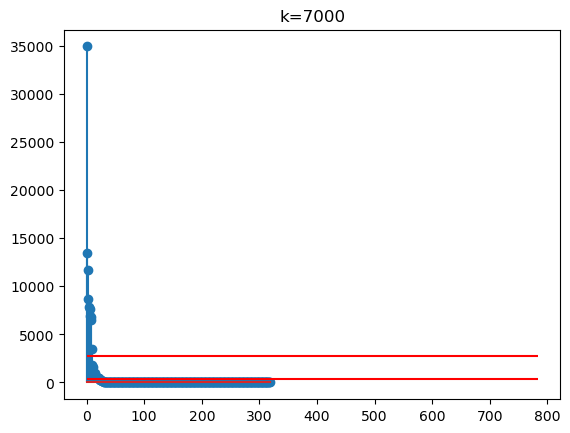

Dimensions: 10


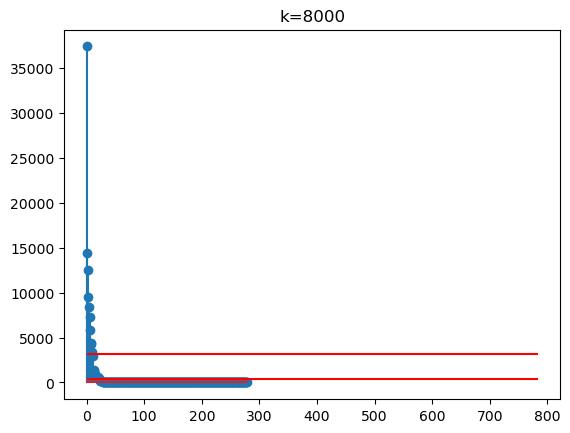

Dimensions: 10


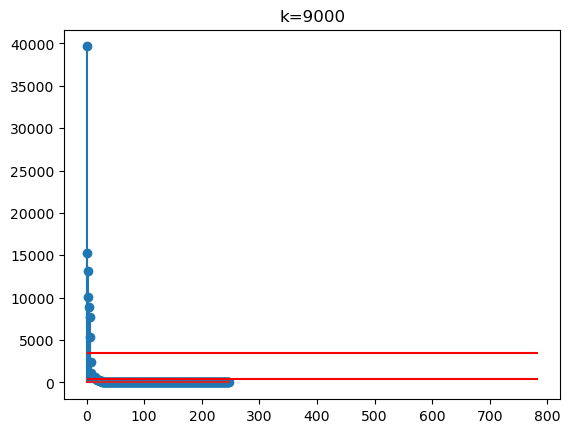

Dimensions: 7


In [22]:
## Visualize the rank of each interval size
n = 1
for k, bbv in bbvs.items():
    U, S, Vh = np.linalg.svd(bbv.T)
    μ = np.mean(S)
    σ = np.std(S)
    clusters = sum(S > (μ + σ))
    
    plt.title(f"k={k}")
    plt.stem(S)
    plt.hlines([μ, μ + n * σ], xmin=0, xmax=783, color="red")
    plt.show()
    print(f"Dimensions: {np.sum(S > (μ + σ))}")

In [18]:
ks = bbvs.keys()
dimensionalities = np.array([])
for k, bbv in tqdm(bbvs.items()):
    pca = PCA(n_components="mle")
    result = pca.fit(bbv.T)
    dimensionalities = np.append(dimensionalities, result.n_components_)
plt.plot(ks, dimensionalities)

 33%|███████████████                              | 3/9 [00:10<00:20,  3.39s/it]


ValueError: n_components='mle' is only supported if n_samples >= n_features

### Clustering

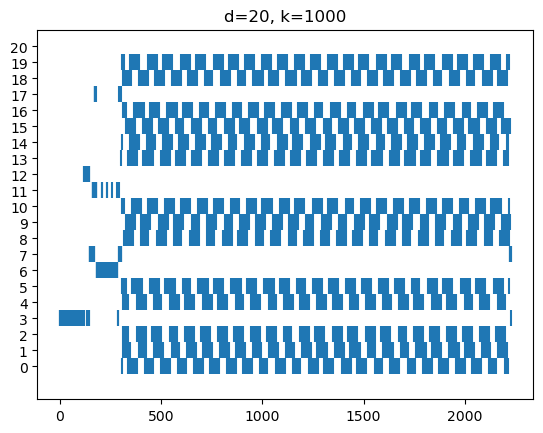

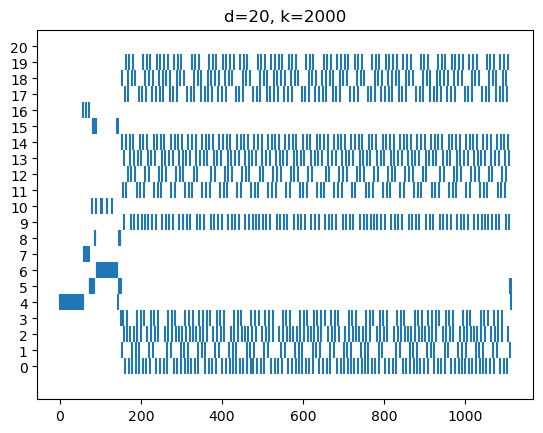

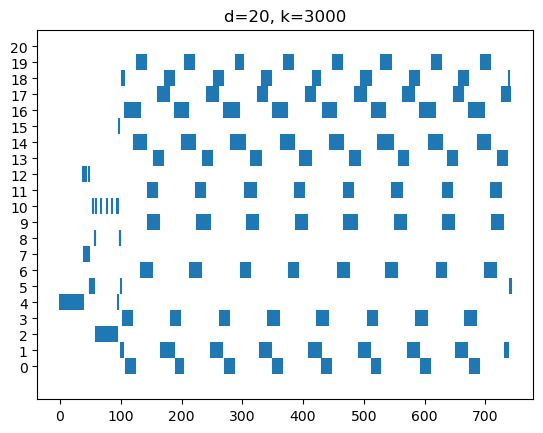

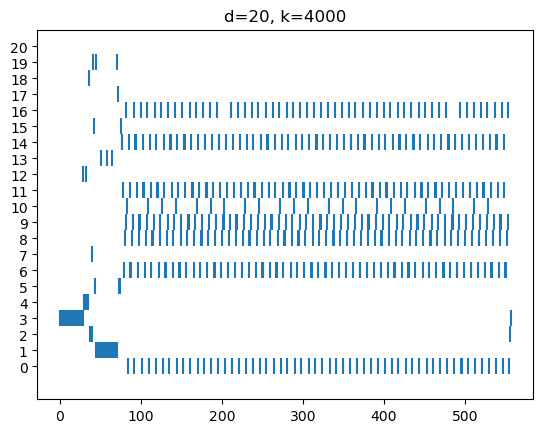

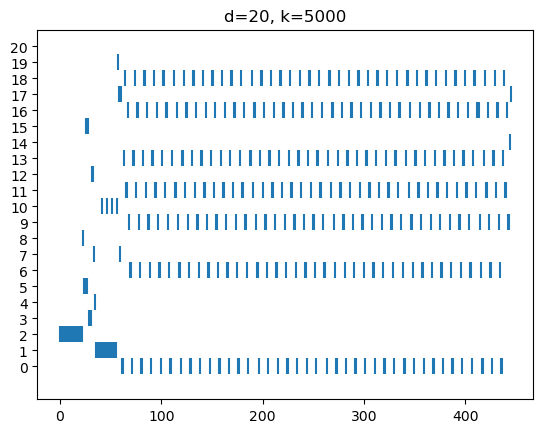

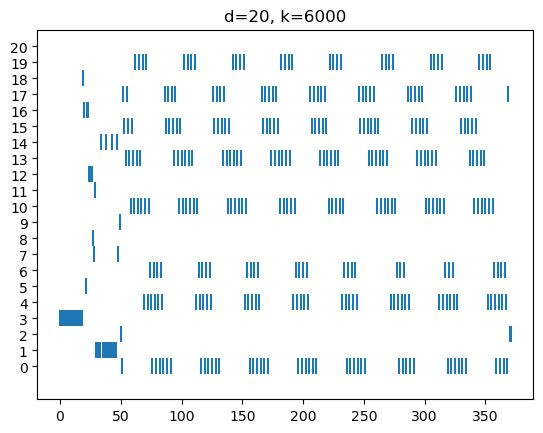

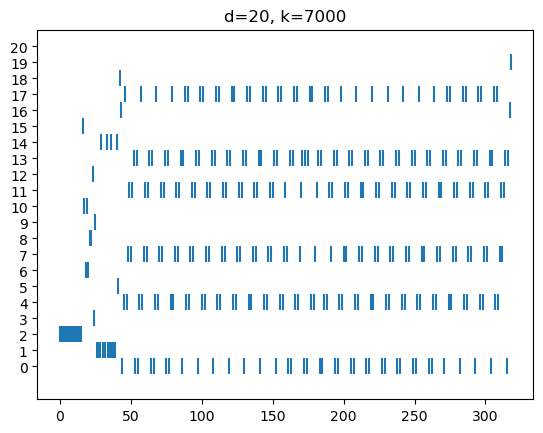

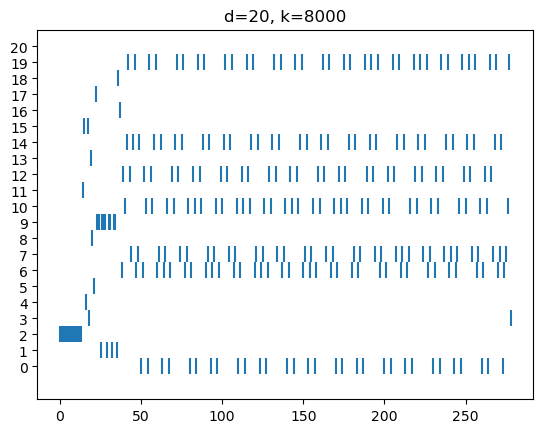

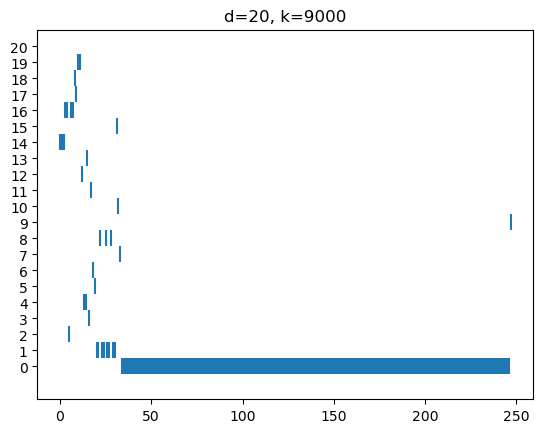

In [28]:
for k, bbv in bbvs.items():
    kmeans = KMeans(n_clusters=20, n_init="auto").fit(bbv.T)
    labels = kmeans.labels_
    
    events = []
    for i in np.unique(labels):
        events.append(np.flatnonzero(labels == i))
    plt.eventplot(events)
    plt.title(f"d=20, k={k}")
    plt.yticks(range(0, 21))
    plt.show()

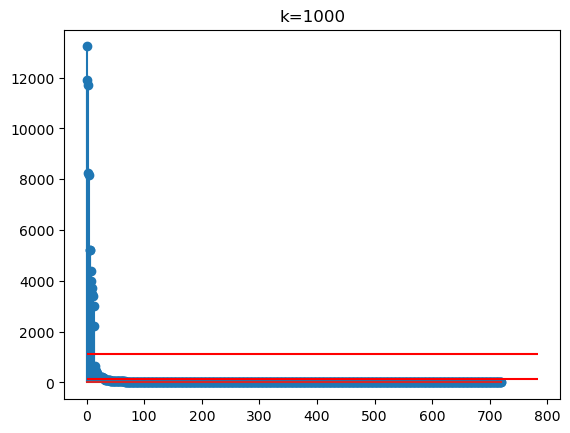

Dimensions: 14


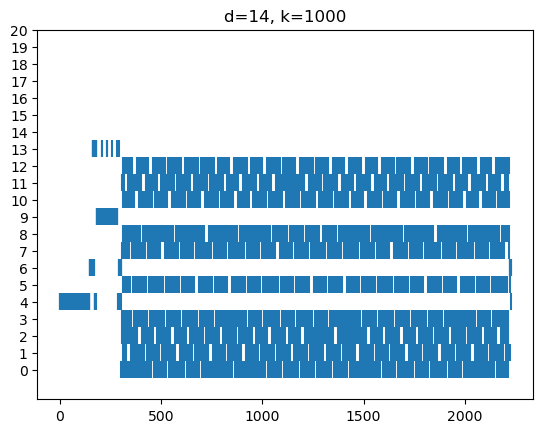

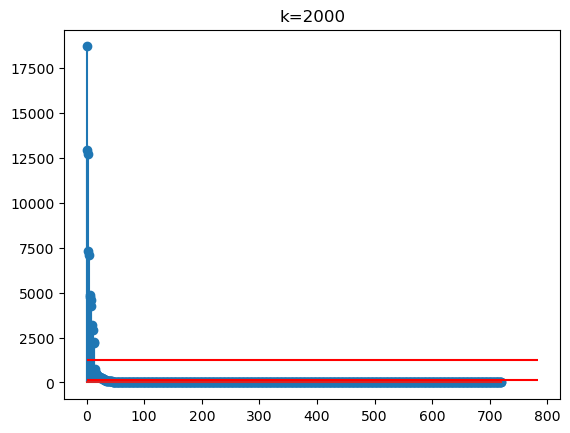

Dimensions: 14


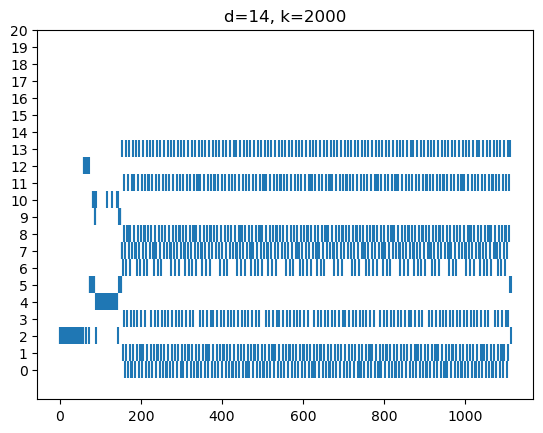

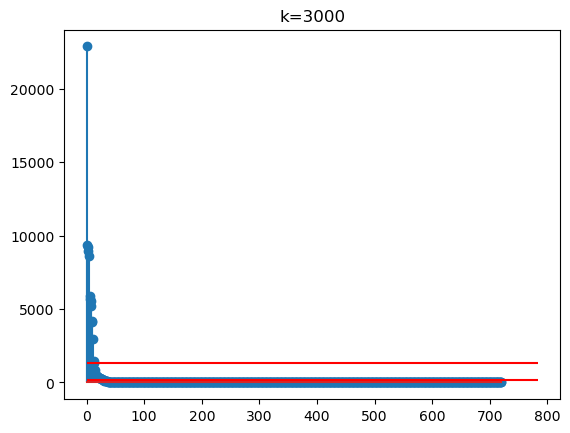

Dimensions: 13


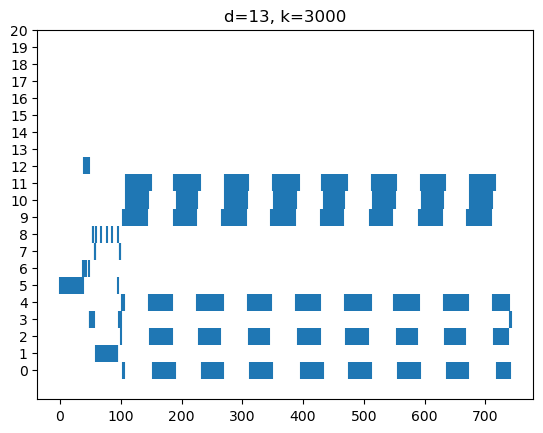

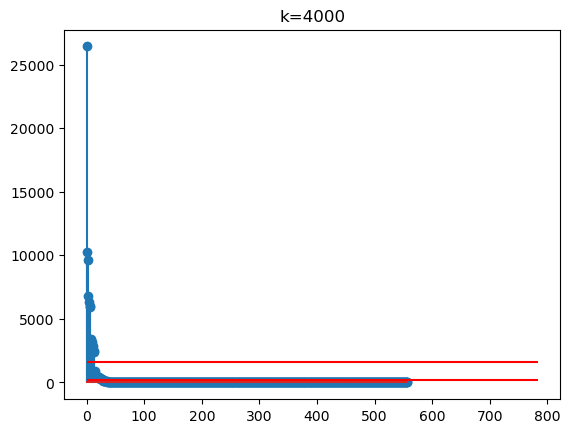

Dimensions: 14


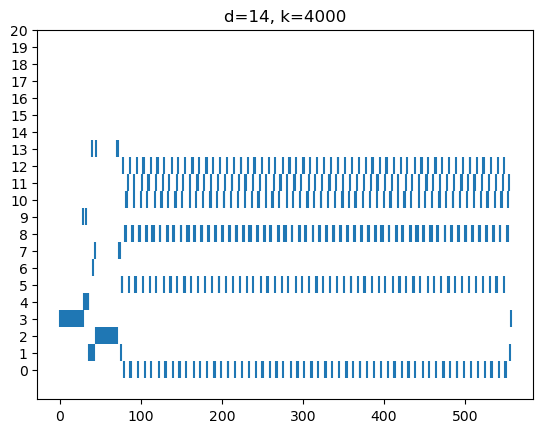

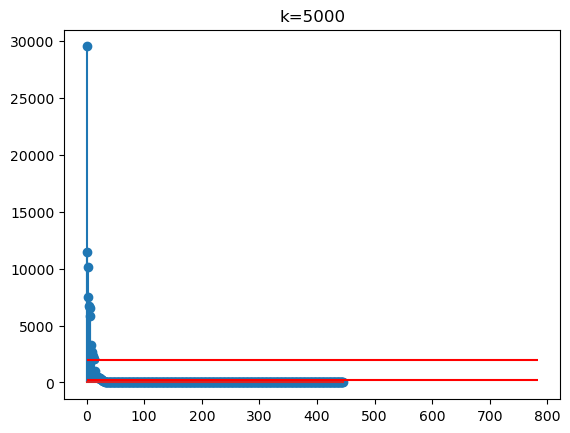

Dimensions: 14


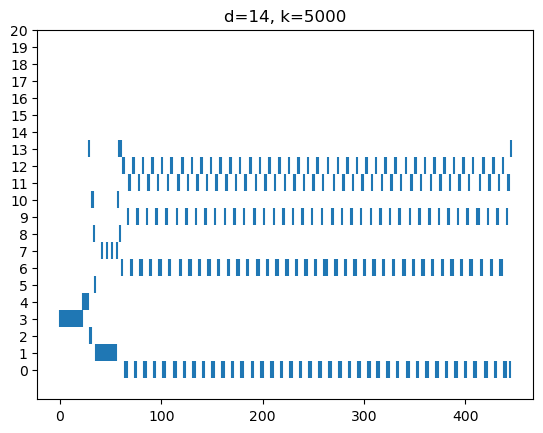

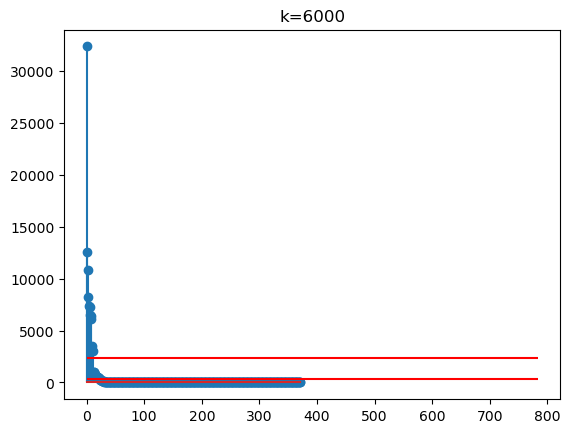

Dimensions: 12


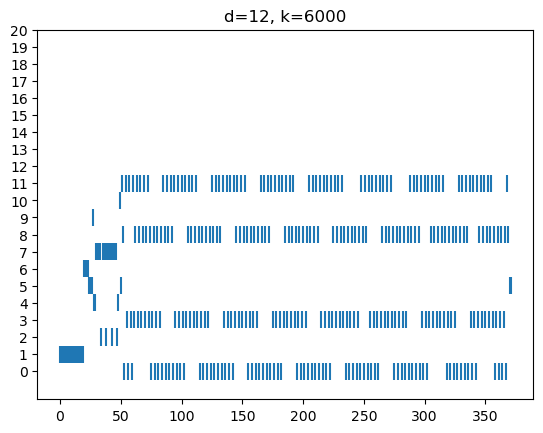

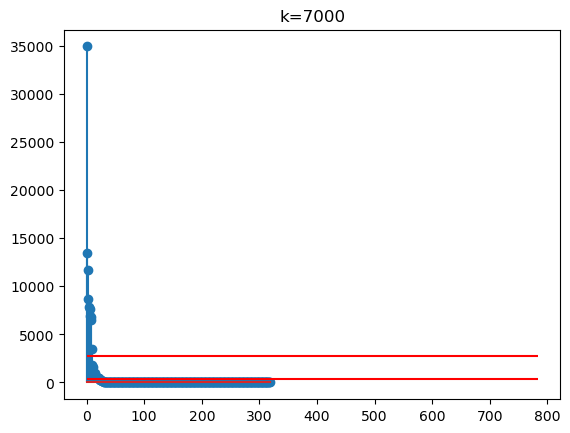

Dimensions: 10


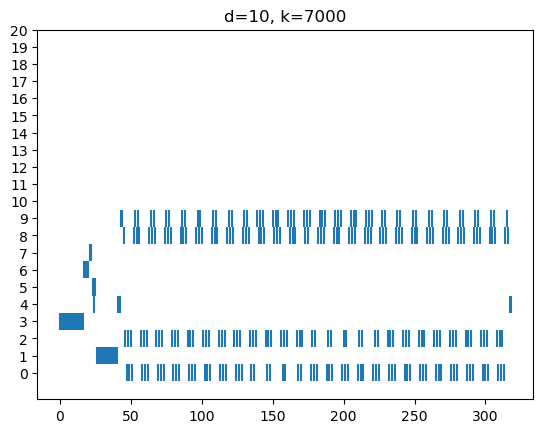

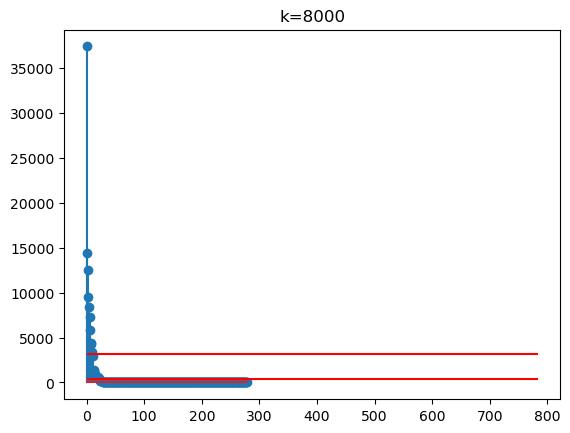

Dimensions: 10


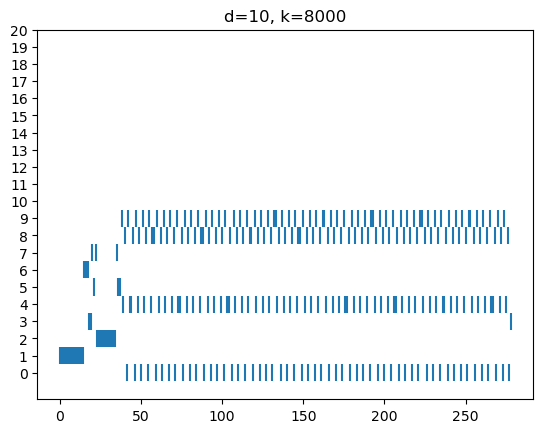

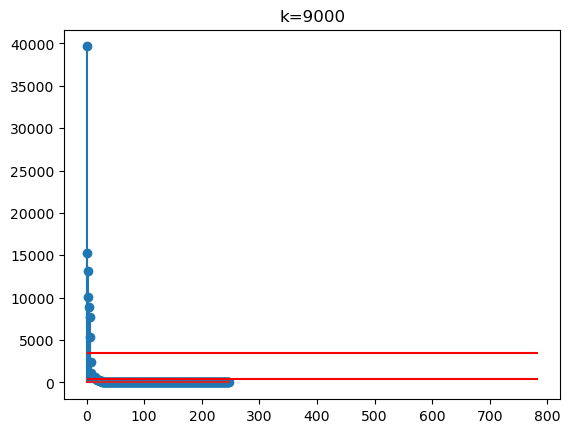

Dimensions: 7


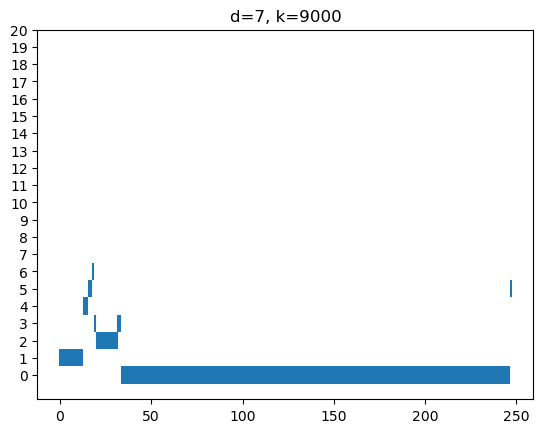

In [27]:
n = 1
for k, bbv in bbvs.items():
    U, S, Vh = np.linalg.svd(bbv.T)
    μ = np.mean(S)
    σ = np.std(S)
    clusters = sum(S > (μ + σ))
    
    plt.stem(S)
    plt.title(f"k={k}")
    plt.hlines([μ, μ + n * σ], xmin=0, xmax=783, color="red")
    plt.show()
    print(f"Dimensions: {np.sum(S > (μ + σ))}")
    kmeans = KMeans(n_clusters=clusters, n_init="auto").fit(bbv.T)
    labels = kmeans.labels_
    
    events = []
    for i in np.unique(labels):
        events.append(np.flatnonzero(labels == i))
    plt.eventplot(events)
    plt.title(f"d={clusters}, k={k}")
    plt.yticks(range(0, 21))
    plt.show()